# Prediccion de Riesgo Crediticio 

### Problema del negocio

Columnas del dataset

| Nombre de la Característica    | Descripción                                   |
| ------------------------------ | --------------------------------------------- |
| person\_age                    | Edad                                          |
| person\_income                 | Ingreso anual                                 |
| person\_home\_ownership        | Propiedad de vivienda                         |
| person\_emp\_length            | Años de empleo (duración del empleo)          |
| loan\_intent                   | Propósito del préstamo                        |
| loan\_grade                    | Calificación del préstamo                     |
| loan\_amnt                     | Monto del préstamo                            |
| loan\_int\_rate                | Tasa de interés                               |
| loan\_status                   | Estado del préstamo (0: no impago, 1: impago) |
| loan\_percent\_income          | Porcentaje del ingreso destinado al préstamo  |
| cb\_person\_default\_on\_file  | Historial de impago                           |
| cb\_person\_cred\_hist\_length | Duración del historial crediticio             |


## Problema.
* Predecir si un cliente sera un buen pagador o un mal pagador.

La importancia de realizar esta prediccion es para minimizar riesgos y evitar perdidas para el banco.

### Lectura del dataset

In [ ]:
# importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from prettytable import PrettyTable

### Limpieza de datos

In [320]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [321]:
print(f'Cantidad de filas del dataset {df.shape[0]}, cantidad de columnas {df.shape[1]}')

Cantidad de filas del dataset 32581, cantidad de columnas 12


In [322]:
# verificar el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [323]:
# verificar si hay valores nulos
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [324]:
# porcentaje de valores nulos
missing_per = df.isnull().sum() / len(df) * 100
print(f'El porcenaje de valores nulos por columna es: \n{missing_per[missing_per > 0]}')

El porcenaje de valores nulos por columna es: 
person_emp_length    2.747000
loan_int_rate        9.563856
dtype: float64


In [325]:
# imputacion de valores nulos
# para la columna 'loan_int_rate' se usara la mediana
loan_rate_mean = df['loan_int_rate'].median()
df['loan_int_rate_imputed'] = df['loan_int_rate'].fillna(loan_rate_mean)

# para la columna 'person_emp_length' se usuta la moda
emp_length_mode = df['person_emp_length'].mode()[0]
df['person_emp_length_imputed'] = df['person_emp_length'].fillna(emp_length_mode)

In [326]:
# eliminar columnas imputadas
df.drop(['loan_int_rate', 'person_emp_length'], axis=1, inplace=True)

In [327]:
# verificar valores duplicados
print(f'La cantidad de filas duplicadas es {df.duplicated().sum()}')

La cantidad de filas duplicadas es 165


In [328]:
# eliminar valores duplicados
df.drop_duplicates(inplace=True)

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   loan_intent                 32416 non-null  object 
 4   loan_grade                  32416 non-null  object 
 5   loan_amnt                   32416 non-null  int64  
 6   loan_status                 32416 non-null  int64  
 7   loan_percent_income         32416 non-null  float64
 8   cb_person_default_on_file   32416 non-null  object 
 9   cb_person_cred_hist_length  32416 non-null  int64  
 10  loan_int_rate_imputed       32416 non-null  float64
 11  person_emp_length_imputed   32416 non-null  float64
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


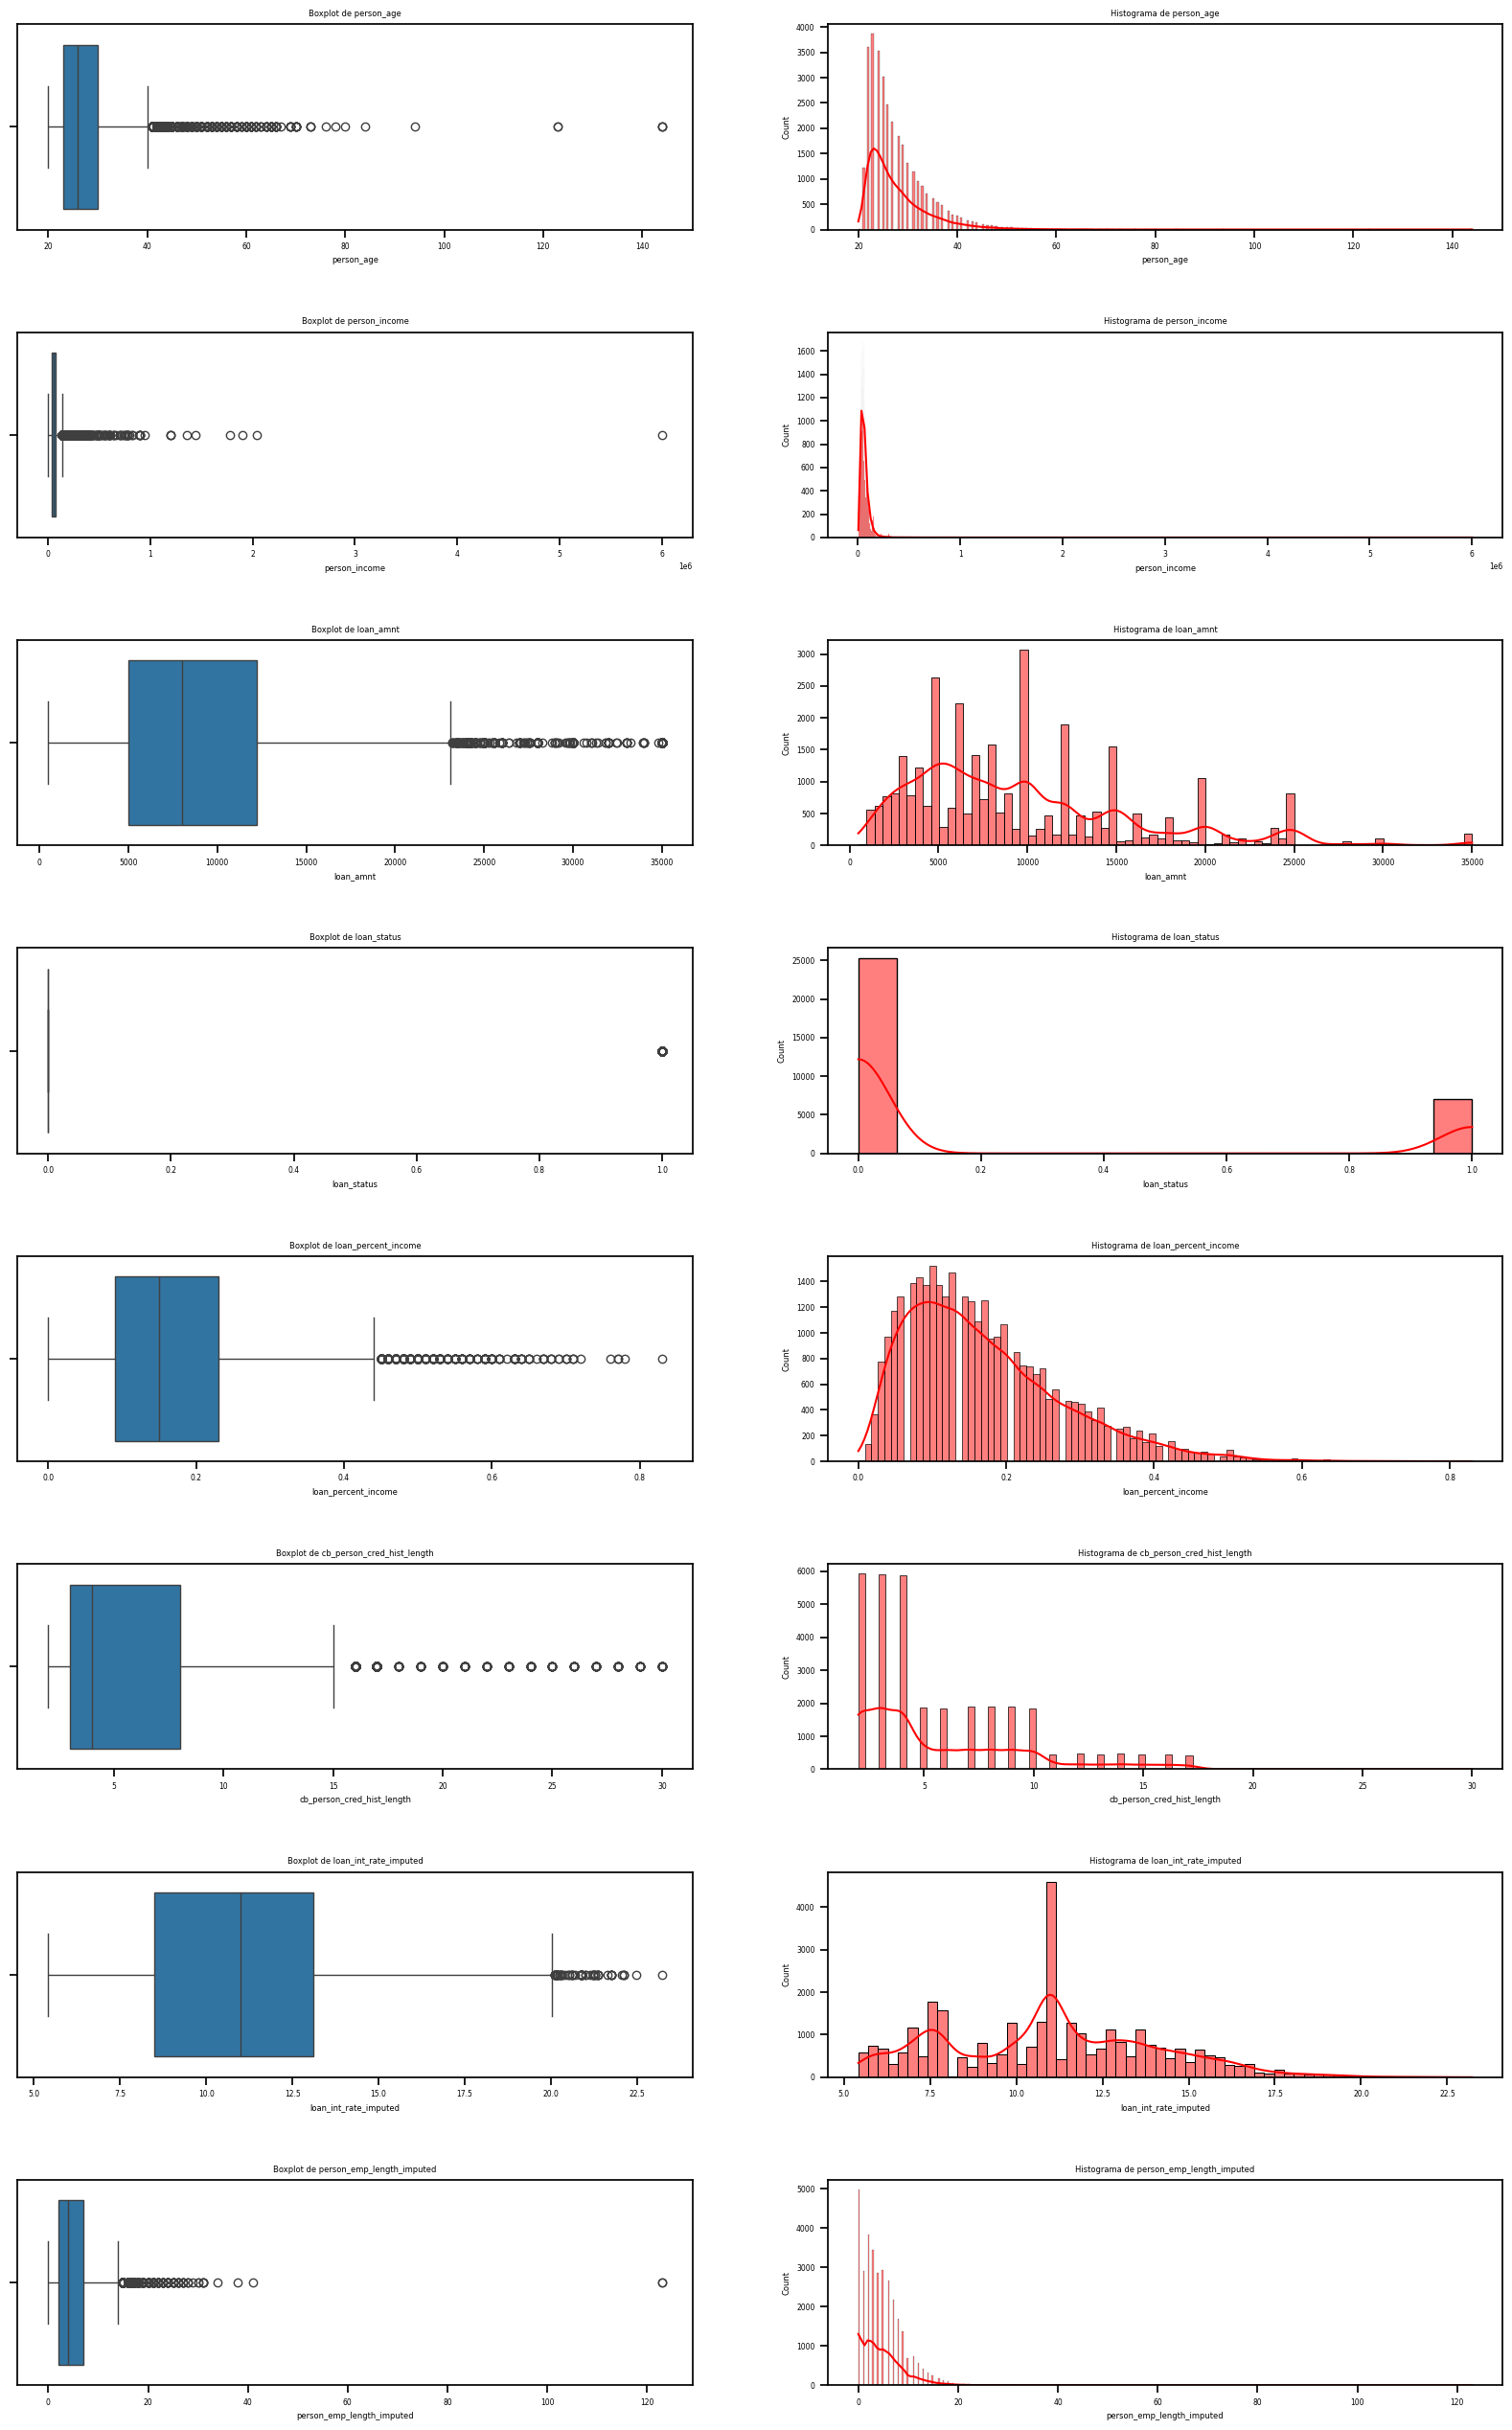

In [332]:
# analisar las variables numericas para el tratamiento de outkiers

# seleccionar las colunas numericas
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# graficar los boxplots para las variables numericas
fig, ax = plt.subplots(ncols=2, nrows=len(numerical_cols), figsize=(20,4*len(numerical_cols)))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=col, data=df, ax=ax[i,0])
    ax[i,0].set_title(f'Boxplot de {col}')
    
    sns.histplot(x=col, data=df, ax=ax[i,1], kde=True, color='red')
    ax[i,1].set_title(f'Histograma de {col}')
    
plt.show()
 

In [333]:
# eliminar outliers pra la variable 'person_age'
print(f'Tamaño original del dataser {df.shape[0]} filas')
df = df[df['person_age'] <= 90]
print(f'El nuevo tamaño del dataser es {df.shape[0]} filas')

Tamaño original del dataser 32416 filas
El nuevo tamaño del dataser es 32410 filas


In [334]:
# eliminar outliers de la variable 'person_emp_length'
print(f'Tamaño original del dataser {df.shape[0]} filas')
df = df[df['person_emp_length_imputed'] <= 60]
print(f'El nuevo tamaño del dataser es {df.shape[0]} filas')

Tamaño original del dataser 32410 filas
El nuevo tamaño del dataser es 32408 filas


### Analisis Exploratorio de Datos

In [381]:
# analizar las variables numericas
df.describe()

,person_age,person_income,loan_amnt,loan_status,loan_percent_income,cb_person_cred_hist_length,loan_int_rate_imputed,person_emp_length_imputed
count,32408.000000,3.240800e+04,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000
mean,27.728709,6.589557e+04,9592.582078,0.218711,0.170245,5.810541,11.014513,4.652061
std,6.199621,5.251816e+04,6320.959306,0.413379,0.106785,4.056254,3.083152,4.057471
min,20.000000,4.000000e+03,500.000000,0.000000,0.000000,2.000000,5.420000,0.000000
25%,23.000000,3.850000e+04,5000.000000,0.000000,0.090000,3.000000,8.490000,2.000000
50%,26.000000,5.500000e+04,8000.000000,0.000000,0.150000,4.000000,10.990000,4.000000
75%,30.000000,7.920000e+04,12250.000000,0.000000,0.230000,8.000000,13.110000,7.000000
max,84.000000,2.039784e+06,35000.000000,1.000000,0.830000,30.000000,23.220000,41.000000


Todos las variables numericas tienen la desviacion estandar diferente de 0 por lo que ninguna tiene valores unicos

In [382]:
# analizar las variables categoricas

# seleccionar las columnas categoricas
categorical_col = df.select_dtypes(include=['object']).columns

# contar los valores unicos en cada columna
for col in categorical_col:
    print(f'{col} tiene: {df[col].value_counts()}')
    print('-'*50)

person_home_ownership tiene: person_home_ownership
RENT        16373
MORTGAGE    13366
OWN          2563
OTHER         106
Name: count, dtype: int64
--------------------------------------------------
loan_intent tiene: loan_intent
EDUCATION            6409
MEDICAL              6041
VENTURE              5679
PERSONAL             5496
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: count, dtype: int64
--------------------------------------------------
loan_grade tiene: loan_grade
A    10702
B    10384
C     6435
D     3619
E      963
F      241
G       64
Name: count, dtype: int64
--------------------------------------------------
cb_person_default_on_file tiene: cb_person_default_on_file
N    26679
Y     5729
Name: count, dtype: int64
--------------------------------------------------


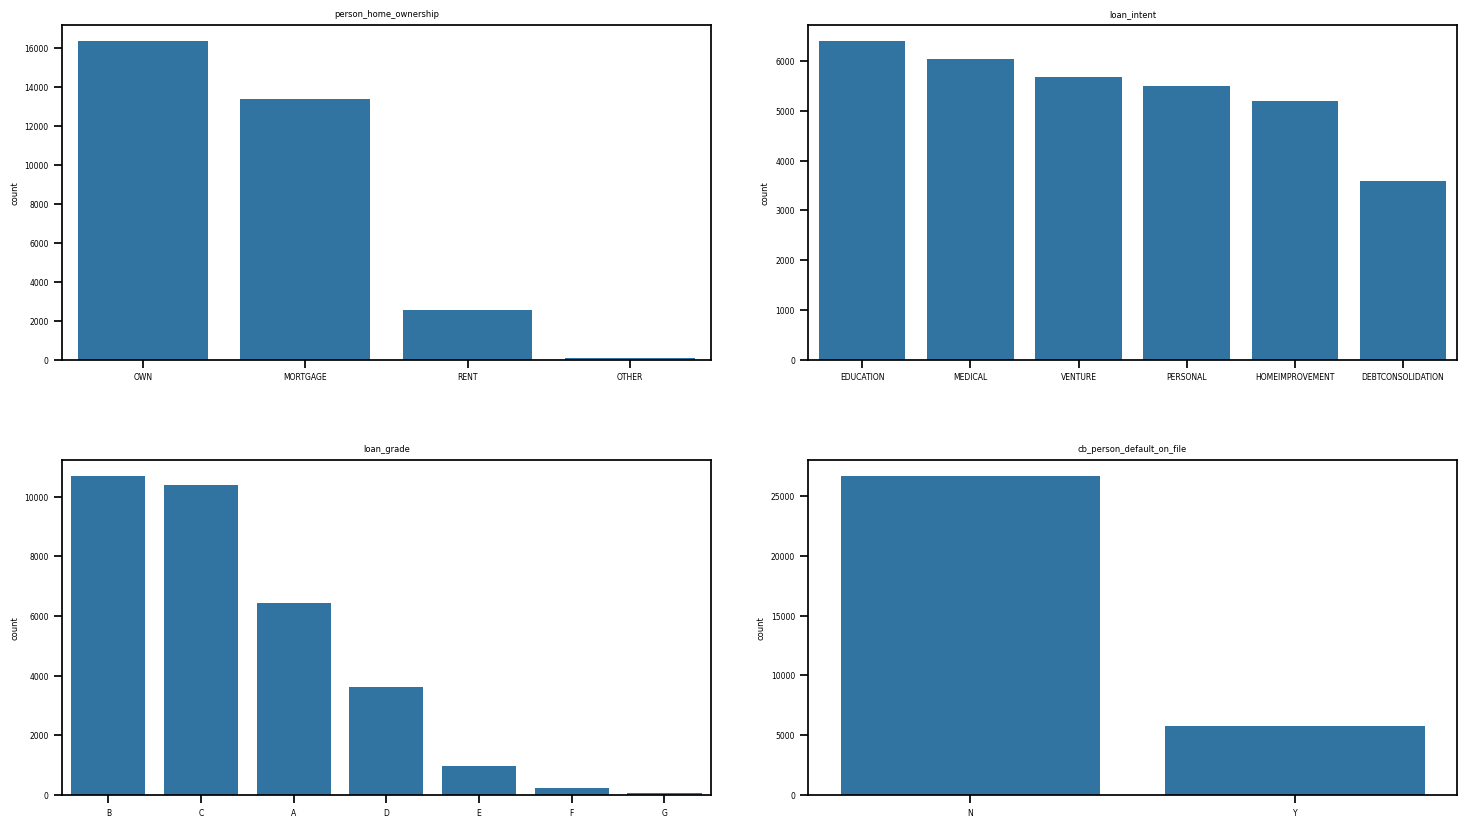

In [383]:
# graficar las variables categoricas
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.15)
ax = ax.flatten()
for i, col in enumerate(categorical_col):
    sns.barplot(x=df[col].unique(), y=df[col].value_counts(), ax=ax[i])
    ax[i].set_title(col)
    
plt.show()


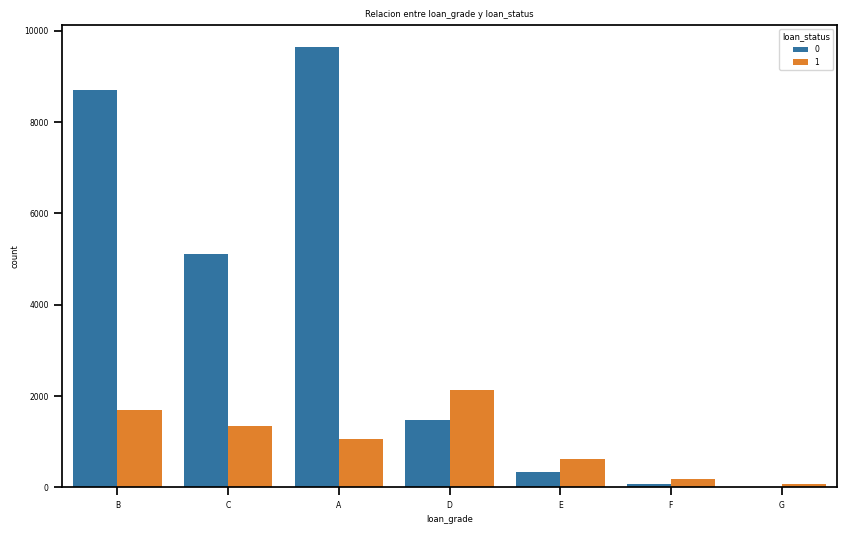

In [384]:
# graficar la relacion entre las variables loan_grade vs loan_status
fig = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, x='loan_grade', hue='loan_status')
plt.title('Relacion entre loan_grade y loan_status')
plt.show()

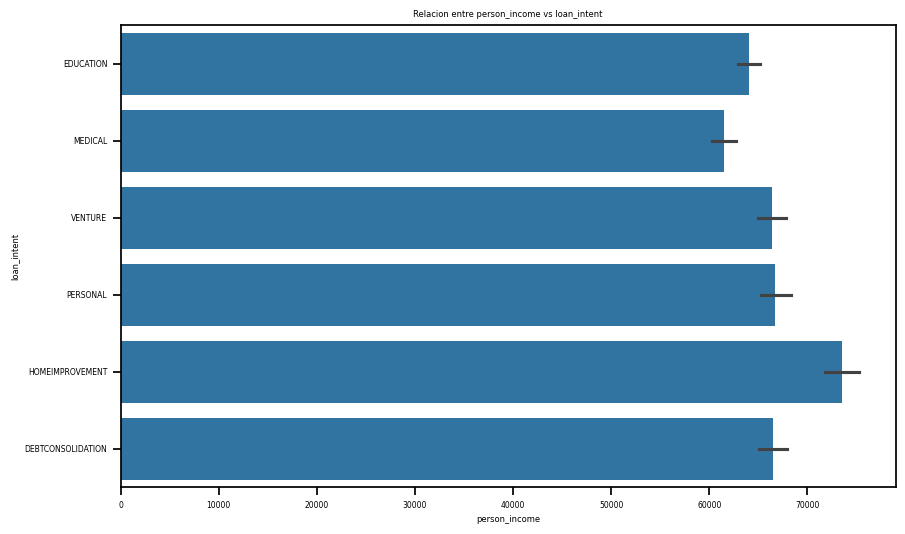

In [385]:
# graficar la relacion entre las variables person_income vs loan_intent
fig = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x='person_income', y='loan_intent')
plt.title('Relacion entre person_income vs loan_intent')
plt.show()

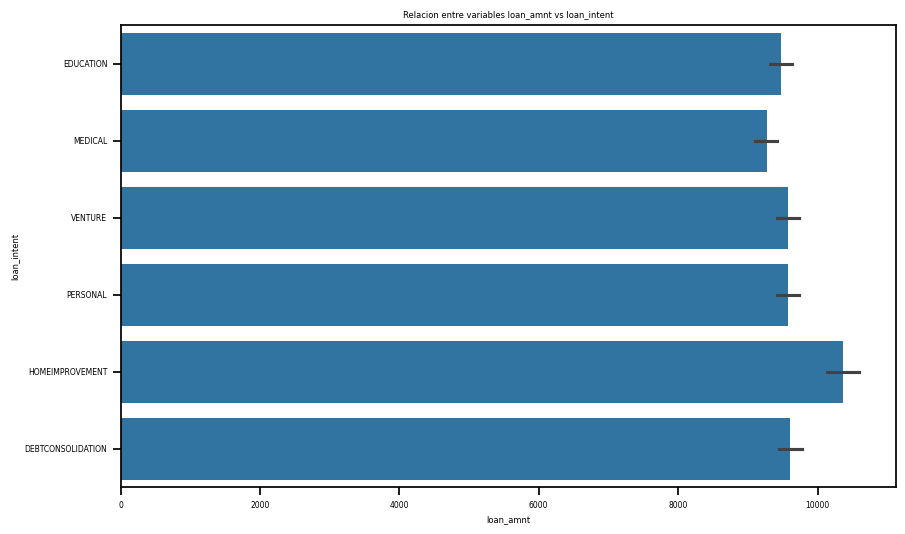

In [386]:
# graficar la relacion entre las variables loan_amnt vs loan_intent
fig = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x='loan_amnt', y='loan_intent')
plt.title('Relacion entre variables loan_amnt vs loan_intent')
plt.show()

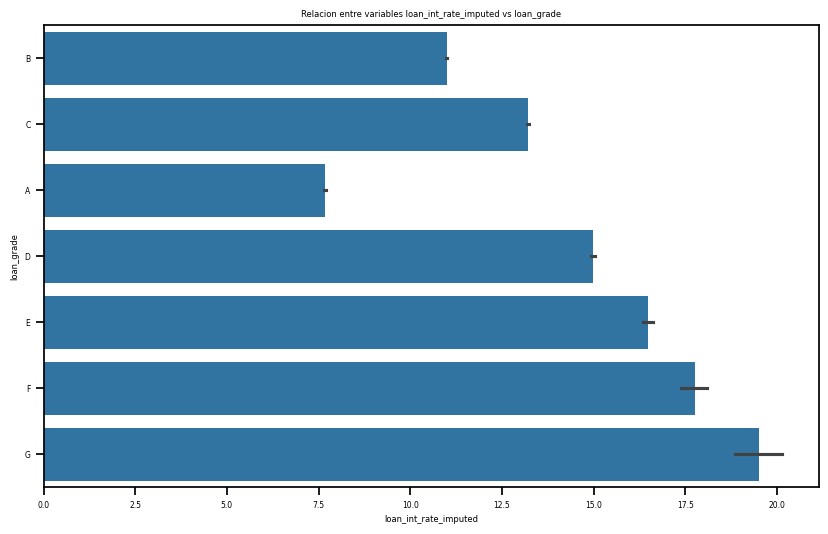

In [387]:
# graficar la relacion entre las variables loan_int_rate_imputed vs loan_grade
fig = plt.subplots(figsize=(10, 6))
sns.barplot(data=df, x='loan_int_rate_imputed', y='loan_grade')
plt.title('Relacion entre variables loan_int_rate_imputed vs loan_grade')
plt.show()

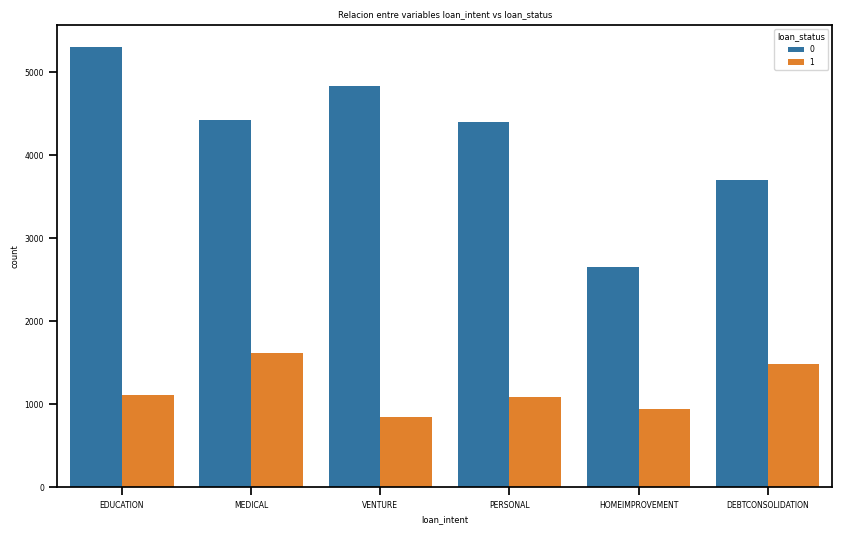

In [388]:
# graficar la relacion entre las variables loan_intent vs loan_status
fig = plt.subplots(figsize=(10, 6))
sns.countplot(data=df, x='loan_intent', hue='loan_status')
plt.title('Relacion entre variables loan_intent vs loan_status')
plt.show()

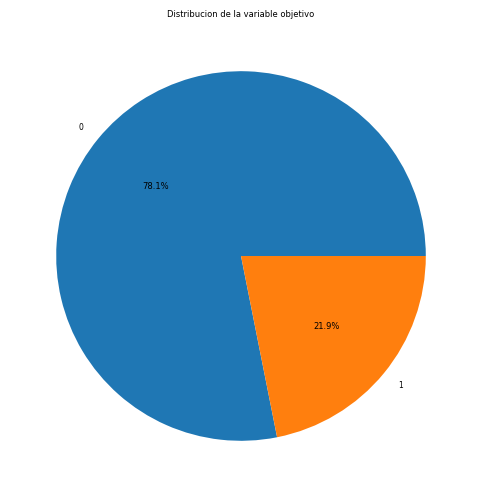

In [394]:
# visualizar y analizar la variable objetivo
fig = plt.subplots(figsize=(10, 6))
plt.pie(df['loan_status'].value_counts(), labels=df['loan_status'].unique(), autopct='%1.1f%%')
plt.title('Distribucion de la variable objetivo')
plt.show()

La variable objetivo cuenta con desbalance en sus datos

### Preprocesamiento y transformacion de los datos

In [397]:
# transformar las variables categoricas a numericas
ordinal_encoder = OrdinalEncoder()
df[categorical_col] = ordinal_encoder.fit_transform(df[categorical_col])

In [398]:
df.describe()

,person_age,person_income,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_int_rate_imputed,person_emp_length_imputed
count,32408.000000,3.240800e+04,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000,32408.000000
mean,27.728709,6.589557e+04,1.677086,2.533294,1.220439,9592.582078,0.218711,0.170245,0.176777,5.810541,11.014513,4.652061
std,6.199621,5.251816e+04,1.433175,1.730831,1.167350,6320.959306,0.413379,0.106785,0.381486,4.056254,3.083152,4.057471
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000,0.000000,2.000000,5.420000,0.000000
25%,23.000000,3.850000e+04,0.000000,1.000000,0.000000,5000.000000,0.000000,0.090000,0.000000,3.000000,8.490000,2.000000
50%,26.000000,5.500000e+04,3.000000,3.000000,1.000000,8000.000000,0.000000,0.150000,0.000000,4.000000,10.990000,4.000000
75%,30.000000,7.920000e+04,3.000000,4.000000,2.000000,12250.000000,0.000000,0.230000,0.000000,8.000000,13.110000,7.000000
max,84.000000,2.039784e+06,3.000000,5.000000,6.000000,35000.000000,1.000000,0.830000,1.000000,30.000000,23.220000,41.000000


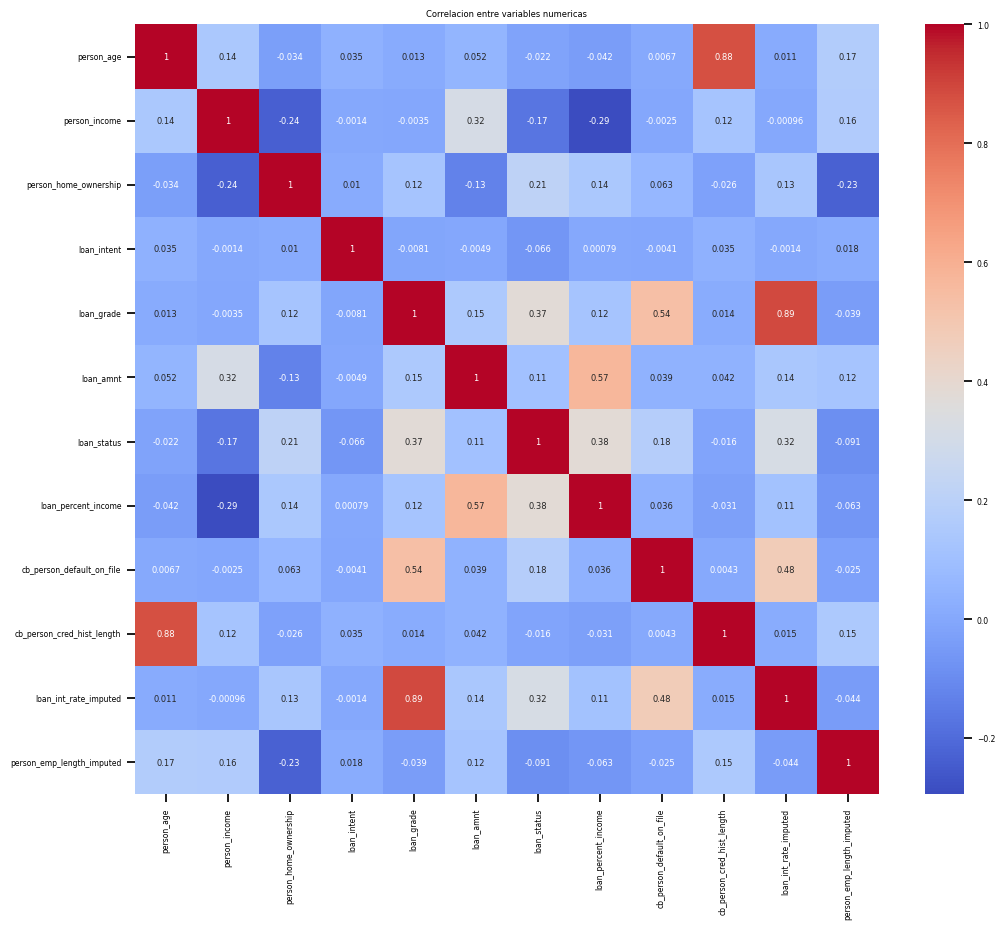

In [399]:
# correlacion entre variables
correlation = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlacion entre variables numericas')
plt.show()

In [401]:
# separamos los datos donde X son las variables independientes y y la variable a predecir
X = df.drop(['loan_status'], axis=1)
y = df['loan_status']

### Entrenamiento del modelo

In [402]:
# dividimos el dataset en train y test con un 80% para el train y 20% para el test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [403]:
# estandarizamos los datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [405]:
# calculo de metricas para evaluar el rendimiento de los modelos
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Classification Report:\n{report}')
    
    # matriz de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusion')
    
    

Accuracy: 0.8374
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5071
           1       0.70      0.44      0.54      1411

    accuracy                           0.84      6482
   macro avg       0.78      0.69      0.72      6482
weighted avg       0.82      0.84      0.82      6482



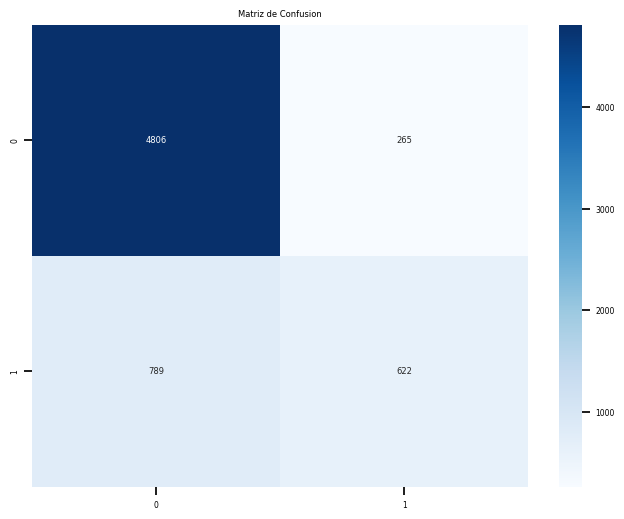

In [406]:
# modelo de regresion logistica
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

evaluate_model(y_test, y_pred)

In [410]:
# modelo de arbol de decision
# entrenamos el modelo para diferentes profundidades
depth = range(5, 20)
results = []
for d in depth:
    decision_tree = DecisionTreeClassifier(max_depth=d)
    decision_tree.fit(X_train, y_train)
    y_pred_tree = decision_tree.predict(X_test)
    results.append(accuracy_score(y_test, y_pred_tree))

# graficamos una tabla con los resultados del accuracy    
table = PrettyTable()
table.field_names = ['Profundidad', 'Accuracy']
for d, acc in zip(depth, results):
    table.add_row([d, round(acc*100, 2)])
    
print(table)

+-------------+----------+
| Profundidad | Accuracy |
+-------------+----------+
|      5      |  90.96   |
|      6      |  92.05   |
|      7      |  92.46   |
|      8      |  92.73   |
|      9      |  92.69   |
|      10     |  92.63   |
|      11     |  92.36   |
|      12     |  92.09   |
|      13     |  91.98   |
|      14     |  91.79   |
|      15     |  91.67   |
|      16     |  91.35   |
|      17     |   90.9   |
|      18     |  90.65   |
|      19     |  90.06   |
+-------------+----------+


Accuracy: 0.9273
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5071
           1       0.97      0.69      0.80      1411

    accuracy                           0.93      6482
   macro avg       0.94      0.84      0.88      6482
weighted avg       0.93      0.93      0.92      6482



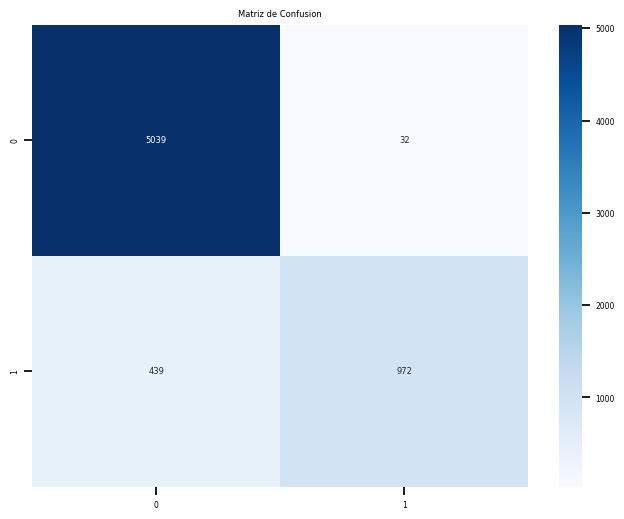

In [447]:
# entrenamos el modelo con la mejor produndidad
best_depth = depth[results.index(max(results))]
decision_tree = DecisionTreeClassifier(max_depth=best_depth)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

evaluate_model(y_test, y_pred)


Accuracy: 0.9224
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      5071
           1       0.96      0.67      0.79      1411

    accuracy                           0.92      6482
   macro avg       0.94      0.83      0.87      6482
weighted avg       0.93      0.92      0.92      6482



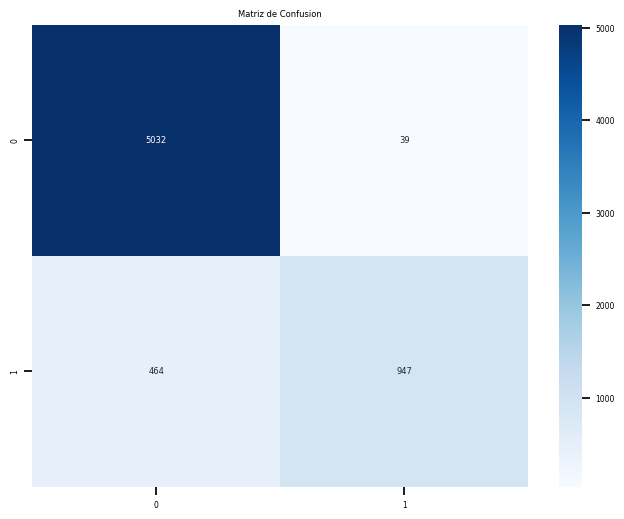

In [428]:
# modelo de random forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=best_depth)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

evaluate_model(y_test, y_pred)

In [435]:
# modelo de random forest con grid search

# ajuste de hiperparametros con GridSeachCV
# definir los hiperparametros a ajustar
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': range(5, 10),               
    'min_samples_split': [2, 5, 10],          
    'min_samples_leaf': [1, 2, 4],            
    'max_features': ['sqrt', 'log2', None]    
}
# inicializar el modelo
rf_model = RandomForestClassifier(random_state=42)
# inicializar GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='accuracy')
# ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)
# obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# realizar predicciones
y_pred_gs = best_rf_model.predict(X_test)
y_pred_prob_gs = best_rf_model.predict_proba(X_test)[:, 1] # para ROC-AUC
# calcular accuracy y ROC-AUC para el mejor modelo
accuracy = accuracy_score(y_test, y_pred_gs)
roc_auc = roc_auc_score(y_test, y_pred_prob_gs)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Accuracy: 0.93
ROC-AUC: 0.93


Accuracy: 0.9269
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5071
           1       0.97      0.68      0.80      1411

    accuracy                           0.93      6482
   macro avg       0.95      0.84      0.88      6482
weighted avg       0.93      0.93      0.92      6482



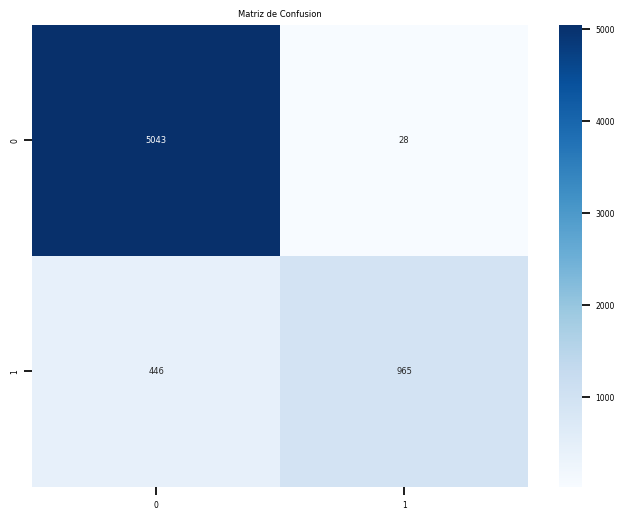

In [438]:
evaluate_model(y_test, y_pred_gs)

Accuracy: 0.8713
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5071
           1       0.78      0.57      0.66      1411

    accuracy                           0.87      6482
   macro avg       0.84      0.76      0.79      6482
weighted avg       0.86      0.87      0.86      6482



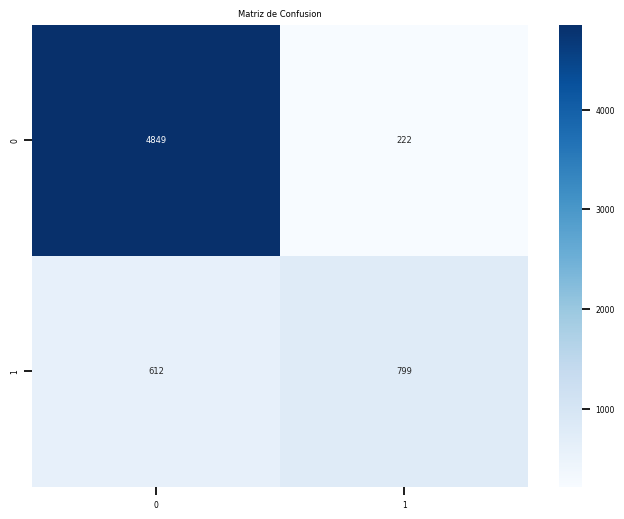

In [444]:
# modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

evaluate_model(y_test, y_pred)

### Conclusiones
* Tras realizar la limpieza y el análisis exploratorio de los datos, se utilizaron todas las columnas del conjunto de datos para predecir si un cliente será buen pagador o mal pagador.
* Se entrenaron cuatro modelos: regresión logística, árbol de decisión (Decision Tree Classifier), bosque aleatorio (Random Forest) y K-Nearest Neighbors con optimización de hiperparámetros mediante Grid Search CV.
* Dos de los modelos implementados alcanzaron una precisión del 93% en las predicciones:
    * El árbol de decisión, optimizando el parámetro de profundidad del árbol.
    * El bosque aleatorio, junto con Grid Search CV para la optimización de sus hiperparámetros.
* Estos modelos permiten predecir con una precisión del 93% si un cliente será buen pagador o no pero el modelo Random Forest mostró el mejor desempeño, logrando un equilibrio adecuado entre precisión y recuperación.

### Recomendaciones
* Para balancear la variable objetivo se podrían usar técnicas de balanceo como SMOTE o undersampling.